In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd


C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the trained model

Since pickle can't save the model class, and we got an error when trying to load the model class. Therefore, we have to redefine the CNNNet model here, then load its trained weights to it.

In [2]:
class CNNNet(nn.Module):
    def __init__(self, n_classes) -> None:
        super(CNNNet, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=75, kernel_size=3, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(75)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=75, out_channels=50, kernel_size=3, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=50, out_channels=25, kernel_size=3, stride=1)
        self.batchnorm3 = nn.BatchNorm2d(25)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride=1)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(2*2*25, 512)
        self.fc2 = nn.Linear(512, self.n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout1(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)

        x = x.view(-1,2*2*25 )
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return self.softmax(x)

model= CNNNet(n_classes = 24)

model_checkpoint = './asl_cnn.pth'
model = torch.load(model_checkpoint)
model.eval()
print(model)

CNNNet(
  (conv1): Conv2d(1, 75, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(75, 50, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=100, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=24, bias=True)
  (softmax): Softmax(dim=1)
)


# Deploying the model


In [3]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

def predict(img_path):
    show_image(img_path)

    # alphabet letter for inference, letter j and z are not included
    alphabet = "abcdefghiklmnopqrstuvwxy"

    # Preparing the image for prediction
    image = Image.open(img_path)
    transform = transforms.Compose([transforms.Grayscale(), 
                                    transforms.Resize([28, 28]), # rescale the image
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
    img = transform(image)
    img = img.reshape(-1,1,28,28) 

    # making prediction on the processed image
    prediction = model(img)
    _, pred_label = torch.max(prediction.data, 1)

    return int(pred_label[0]), alphabet[pred_label[0]]




(1, 'b')

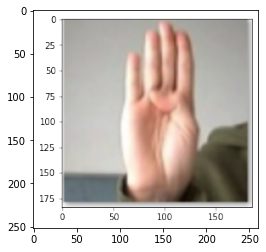

In [4]:
predict('../data/b.png')

(0, 'a')

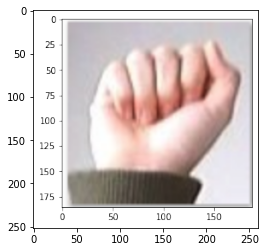

In [5]:
predict('../data/a.png')